# DeepFake Image detection

## About the Dataset

This dataset contains faces extracted from deepfake-detection-challenge. All images were of size 224x224. 

Due to memory issue we will only use a sample of the entire dataset for prediction.

## Importing Required libraries

In [4]:
!pip install tensorflow==2.15.0
!pip install wurlitzer

  Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.56 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.


In [5]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

2024-04-09 06:29:57.838401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 06:29:57.838455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 06:29:57.839847: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
tf.test.is_gpu_available()

True

In [7]:
tf.__version__

'2.15.0'

In [9]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Data Visualisation

In [10]:
import os

def get_data():
    return pd.read_csv('../input/deepfake-faces/metadata.csv')

In [11]:
meta=get_data()
meta.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [12]:
meta.shape

(95634, 5)

In [13]:
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])

(79341, 16293)

In [14]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 16000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

As mentioned instead of using 95k images we will only use 16000x2 images.

In [15]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

In [16]:
Train_set.shape,Val_set.shape,Test_set.shape

((17920, 5), (7680, 5), (6400, 5))

In [17]:
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)

The original image dataset were biased with more fake images than real since we are taking a sample of it its better to take equal proportion of real and fake images.

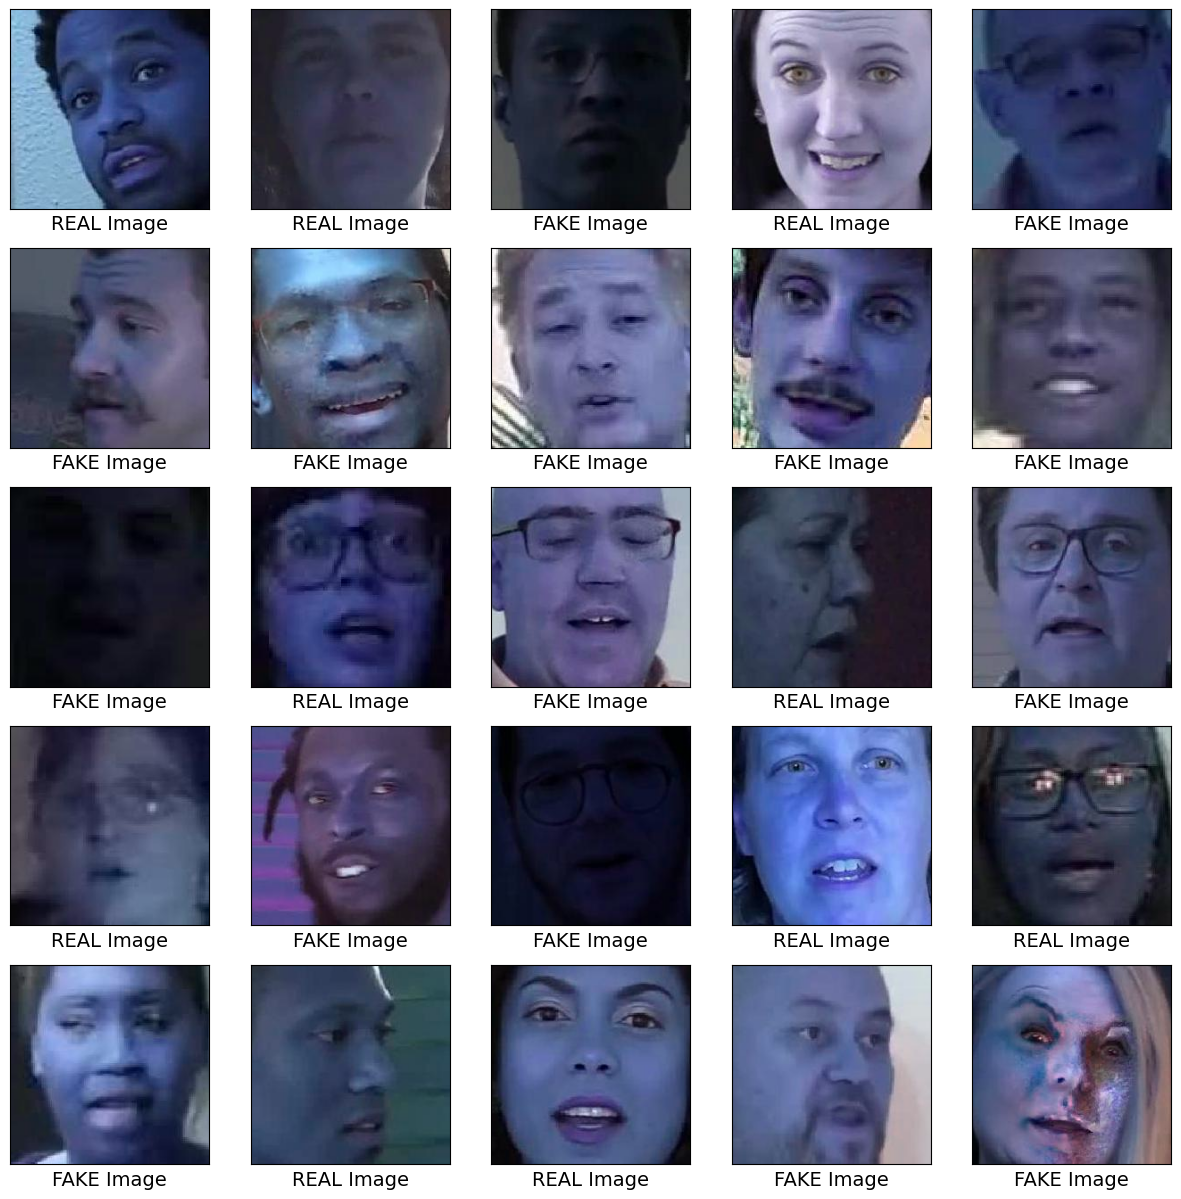

In [18]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread('../input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

## Modelling

Before jumping to use pretrained model lets develop some base line model to test how our pretrained model outperforms.

### Custom CNN Architecture

In [19]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels)

In [20]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [21]:
from functools import partial

tf.random.set_seed(42) 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [22]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 401408)            0

In [23]:
history = model.fit(X_train, y_train, epochs=5,batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/5


I0000 00:00:1712644605.956671     134 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


280/280 [==============================] - 104s 303ms/step - loss: 31.6569 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 2/5
280/280 [==============================] - 81s 291ms/step - loss: 0.6933 - accuracy: 0.4963 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
280/280 [==============================] - 82s 291ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
280/280 [==============================] - 81s 291ms/step - loss: 0.6933 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
280/280 [==============================] - 82s 291ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5000


In [24]:
score = model.evaluate(X_test, y_test)

200/200 [==============================] - 11s 39ms/step - loss: 0.6932 - accuracy: 0.5000


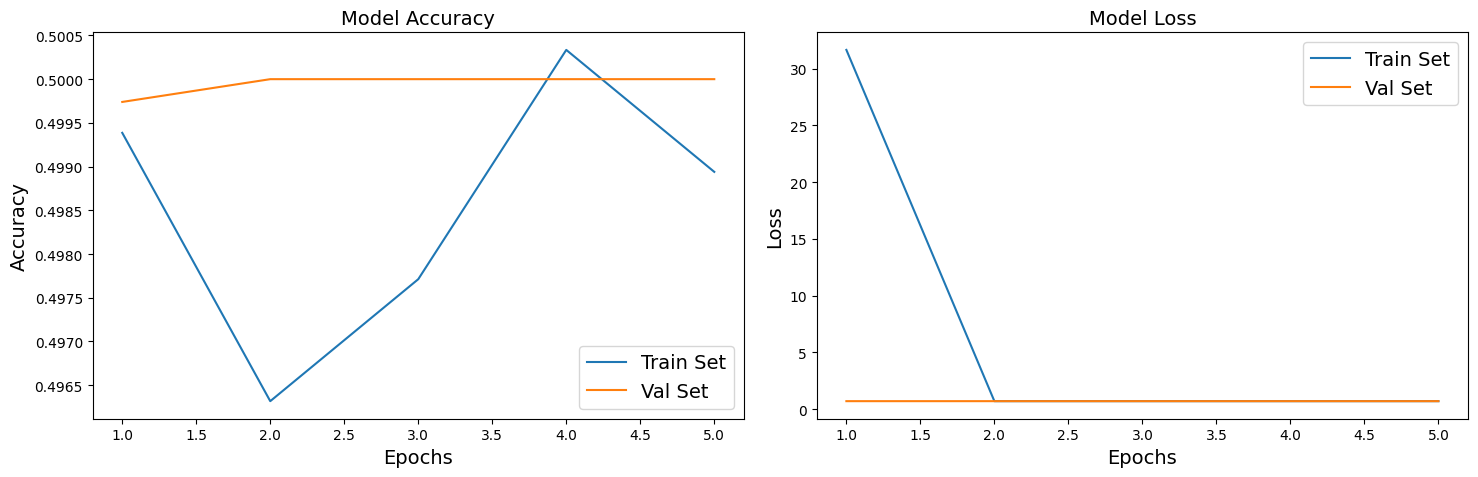

In [25]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

A baseline score of 50.06% is good to go let's finetune some pretrained model

# Pretrained Models for Transfer Learning

Here i used Xception model for fine-tuning feel free to try the performance of other pretrained models.

All three datasets contain individual images. We need to batch them, but for this we first need to ensure they all have the same size, or else batching will not work. We can use a `Resizing` layer for this. We must also call the `tf.keras.applications.xception.preprocess_input()` function to preprocess the images appropriately for the Xception model. We will also add shuffling and prefetching to the training dataset.

In [26]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [27]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

Let's take a look again at the first 9 images from the validation set: they're all with values ranging from -1 to 1:

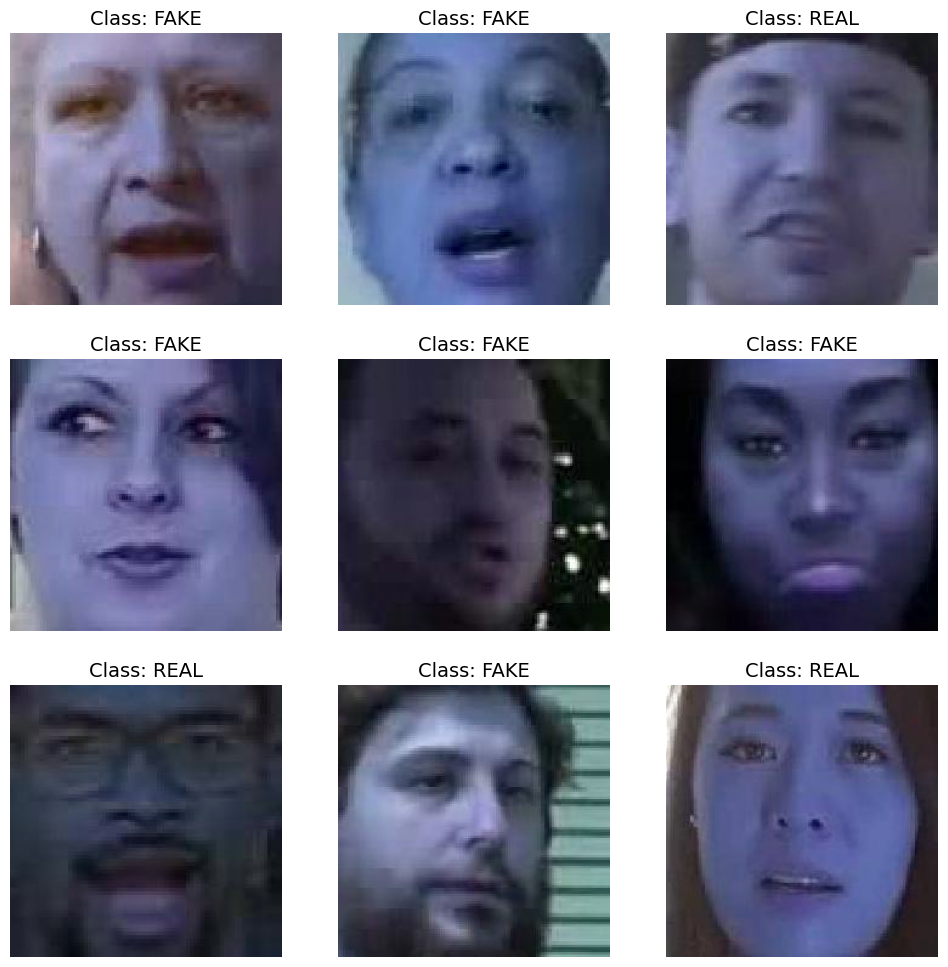

In [28]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [29]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

Try running the following cell multiple times to see different random data augmentations:

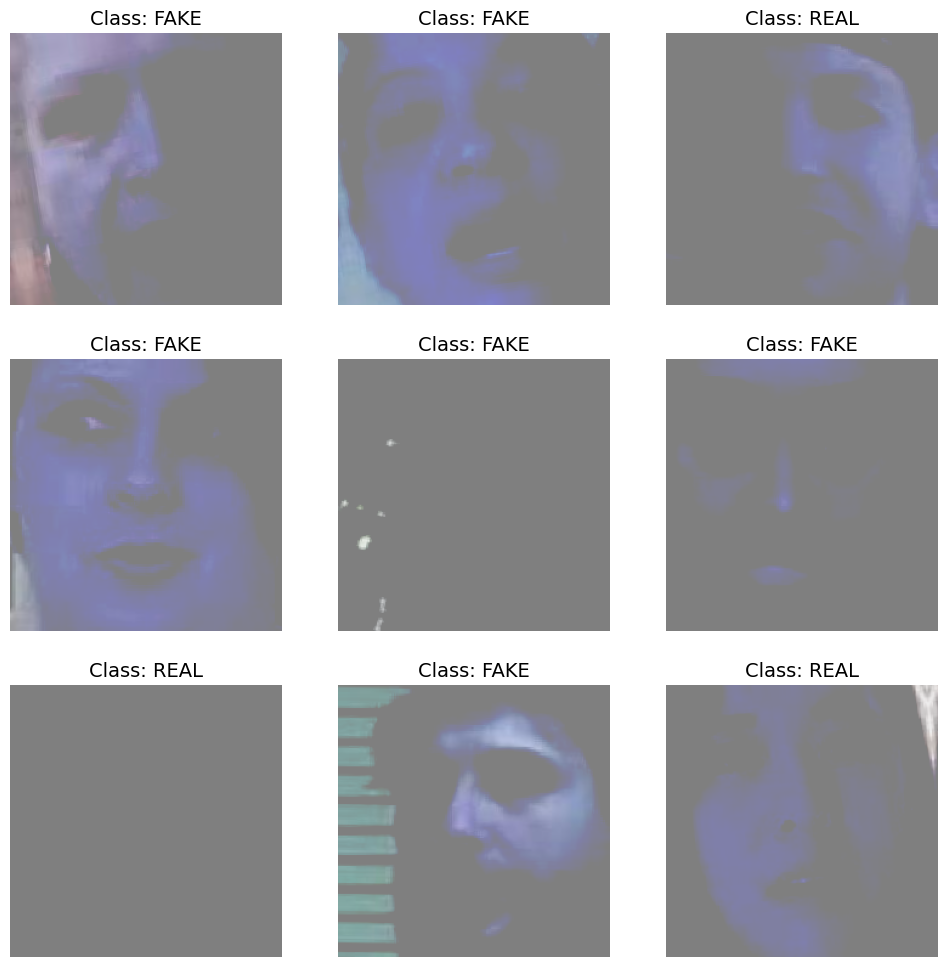

In [30]:
# extra code – displays the same first 9 images, after augmentation

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

Now let's load the pretrained model, without its top layers, and replace them with our own task

In [31]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 0s 0us/step


In [32]:
for layer in base_model.layers:
    layer.trainable = False

Let's train the model for a few epochs, while keeping the base model weights fixed:

In [33]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
560/560 [==============================] - 118s 199ms/step - loss: 1.1263 - accuracy: 0.5869 - val_loss: 0.8217 - val_accuracy: 0.6180
Epoch 2/3
560/560 [==============================] - 109s 194ms/step - loss: 0.9827 - accuracy: 0.6164 - val_loss: 0.7597 - val_accuracy: 0.6448
Epoch 3/3
560/560 [==============================] - 109s 194ms/step - loss: 0.9467 - accuracy: 0.6331 - val_loss: 0.7765 - val_accuracy: 0.6507


In [34]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [35]:
model.evaluate(test_set)

200/200 [==============================] - 28s 136ms/step - loss: 0.7713 - accuracy: 0.6527


[0.7713117003440857, 0.6526562571525574]

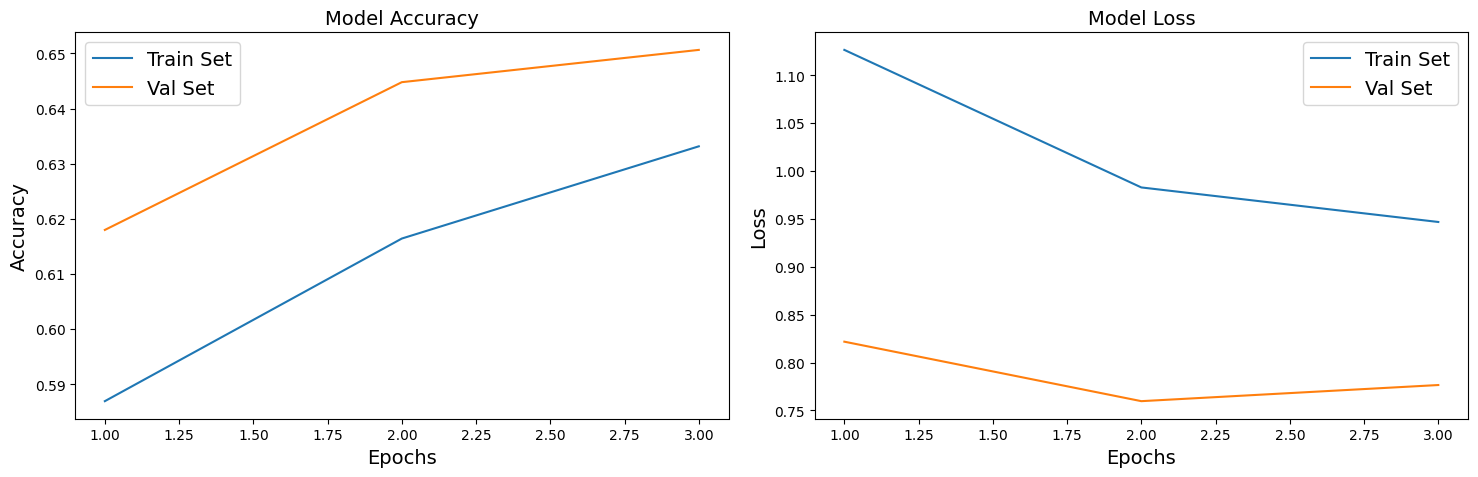

In [36]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Now with the finetuning the top layers of xception model the model performance jumps to 63.8% 

Now that the weights of our new top layers are not too bad, we can make the top part of the base model trainable again, and continue training, but with a lower learning rate:

In [37]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
560/560 [==============================] - 206s 348ms/step - loss: 0.5451 - accuracy: 0.7157 - val_loss: 0.5263 - val_accuracy: 0.7365
Epoch 2/10
560/560 [==============================] - 193s 345ms/step - loss: 0.2866 - accuracy: 0.8741 - val_loss: 0.4602 - val_accuracy: 0.8201
Epoch 3/10
560/560 [==============================] - 193s 345ms/step - loss: 0.1603 - accuracy: 0.9353 - val_loss: 0.5723 - val_accuracy: 0.8163
Epoch 4/10
560/560 [==============================] - 193s 345ms/step - loss: 0.1127 - accuracy: 0.9565 - val_loss: 0.4809 - val_accuracy: 0.8469
Epoch 5/10
560/560 [==============================] - 193s 345ms/step - loss: 0.0752 - accuracy: 0.9725 - val_loss: 0.7909 - val_accuracy: 0.8036
Epoch 6/10
560/560 [==============================] - 193s 345ms/step - loss: 0.0623 - accuracy: 0.9778 - val_loss: 0.6273 - val_accuracy: 0.8299
Epoch 7/10
560/560 [==============================] - 193s 345ms/step - loss: 0.0490 - accuracy: 0.9830 - val_loss: 0.6180 -

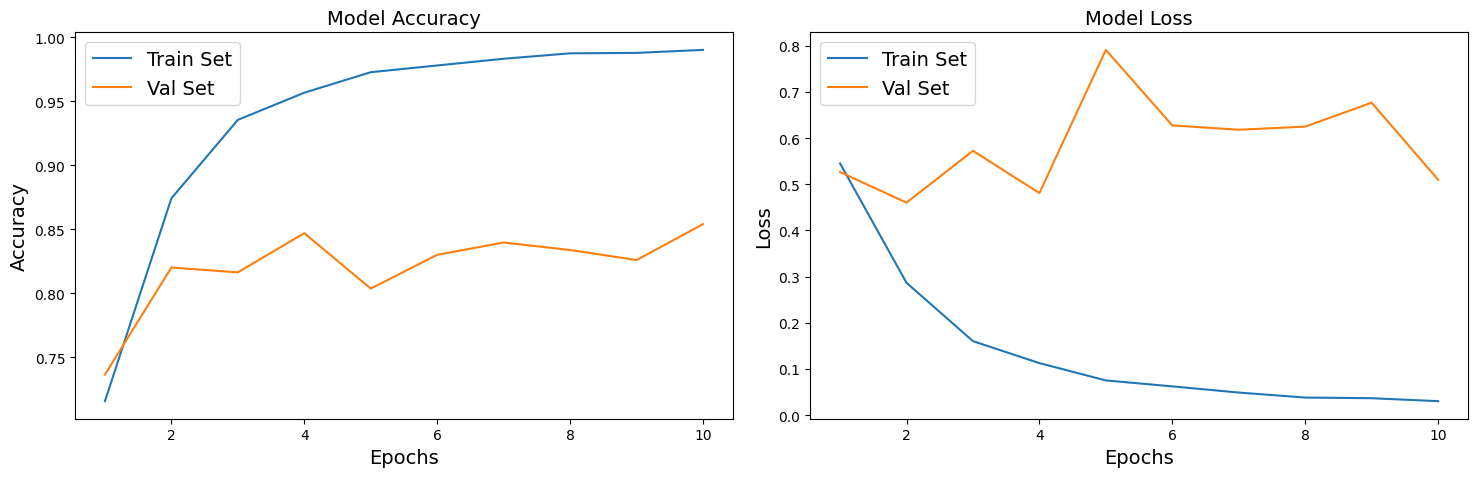

In [38]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [39]:
model.evaluate(test_set)

200/200 [==============================] - 27s 137ms/step - loss: 0.5161 - accuracy: 0.8539


[0.5161376595497131, 0.8539062738418579]

The model accuracy finally reaches to 81.9%

In [40]:
model.save('xception_deepfake_image.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [41]:
import cv2

# Read the image
image_path = "/kaggle/input/deepfake-faces/faces_224/aaagqkcdis.jpg"  # Path to your image file
image = cv2.imread(image_path)

In [42]:
# Resize the image to match the model's input shape
resized_image = cv2.resize(image, (224, 224))

# Normalize the image
normalized_image = resized_image / 255.0  # Assuming the model expects pixel values between 0 and 1

# Add batch dimension to match the model's input shape
input_image = np.expand_dims(normalized_image, axis=0)

In [43]:
# Assuming `image` is the preprocessed image
prediction = model.predict(input_image)

1/1 [==============================] - 2s 2s/step


In [44]:
print(prediction)

[[0.9999677]]


# Add Explainability to the model

Lets try to interpret the trained model on how it finds a image FAKE

In [45]:
!pip install lime

In [46]:
from lime import lime_image
import matplotlib.pyplot as plt

explainer = lime_image.LimeImageExplainer()

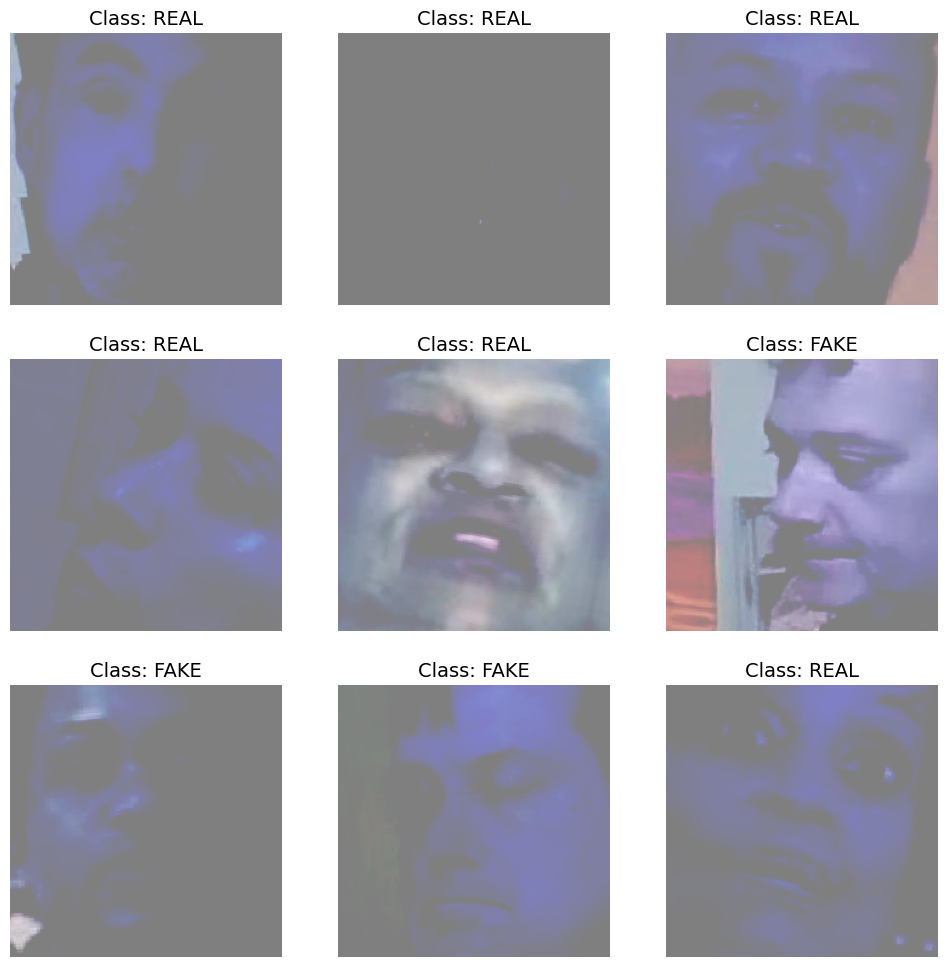

In [47]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [48]:
test_data = X_test[2,:,:,:]
for X_batch, y_batch in test_set.take(1):
    test_data = data_augmentation(X_batch, training=True)

test_data = np.array(test_data[2,:,:,:])
test_data.shape

(224, 224, 3)

In [49]:
explanation = explainer.explain_instance(test_data.astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


(-0.5, 223.5, 223.5, -0.5)

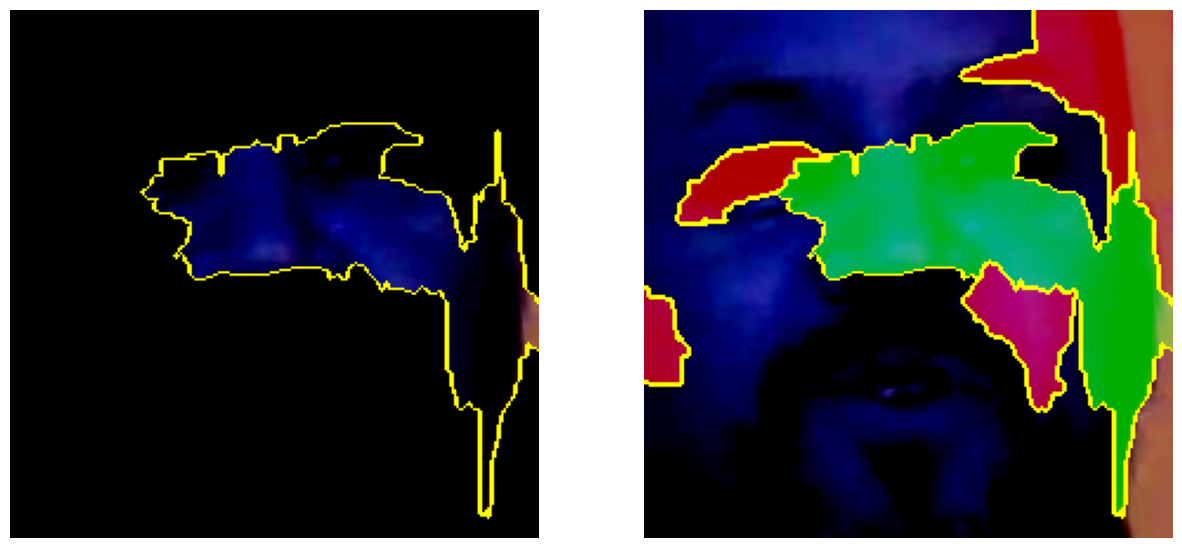

In [50]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')